# PyTorch Computer Vision

## 1. Computer vision in PyTorch 
* [`torchvision`] - base library for PyTorch computer vision 
* `torchvision.dataset` - datasets and data loading function for computer vision
* `torchvision.models` - get pretrained computer vision models that you can leverage for applications
* `torchvision.transform` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [1]:
# Import torch
import torch
from torch import nn 

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import utils

# Import matplotlib for visulization
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


## 2. Getting a dataset
The dataset from torch vision called FashionMNIST - the same manner as MNIST number datasets

In [5]:
# Setup training data
train_data = datasets.FashionMNIST(
	root="data",
	train=True,
	download=True,
	transform=torchvision.transforms.ToTensor(),
	target_transform=None
	)

test_data = datasets.FashionMNIST(
	root="data",
	train=False,
	download=True,
	transform=torchvision.transforms.ToTensor(),
	target_transform=None
)

### 1.1 Check input shape of data

In [15]:
# Training
image, label = train_data[0]
print(train_data.class_to_idx)
print(image.shape)
print(label)

class_name = train_data.classes
print(class_name[label])

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
torch.Size([1, 28, 28])
9
Ankle boot


### 1.2 Visualizing the data

Image shape; torch.Size([1, 28, 28])


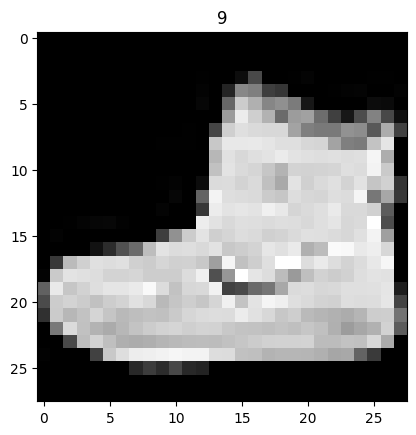

In [19]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f"Image shape; {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)

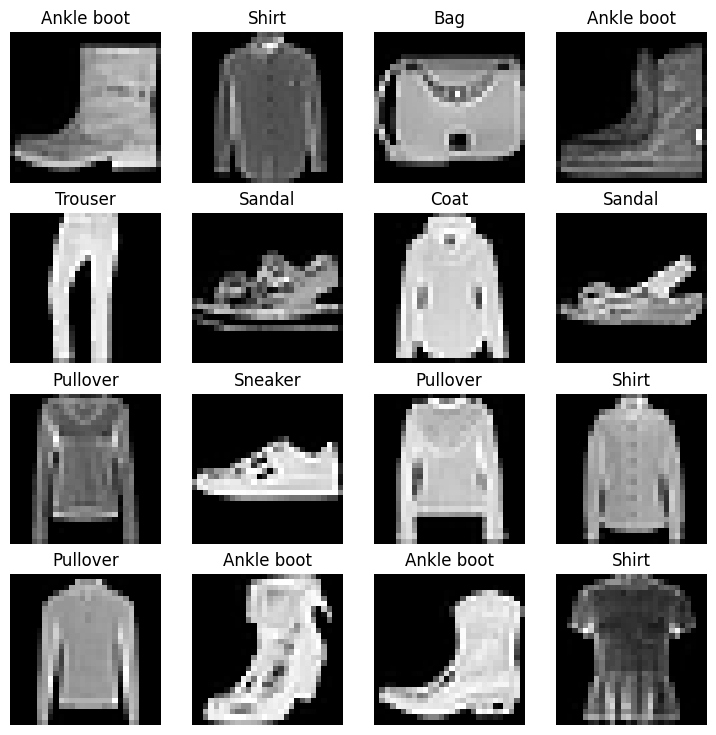

In [31]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
class_name = train_data.classes

for i in range(1, rows*cols+1):
	random_idx = torch.randint(0, len(train_data), size=[1]).item()
	image, label = train_data[random_idx]
	fig.add_subplot(rows,cols,i)
	plt.imshow(image.squeeze(), cmap="gray")
	plt.title(class_name[label])
	plt.axis(False)

## 3. Prepare DataLoader

Above data is in PyTorch datasets

And it is necessary to turn our dataset into PYthon iterable

Why? Ram is limited and we cannot load milions of data into just one object:
1. It is more computationally efficient, computer will not always have resources to look at 60000 images in one time. So we split the dataset up to smaller set called batch, commonly 32 images at a time. 
2. It gives our neural network more chances to update its gradient per epoch. 

The theory for minibatches once gain, will not be repeated here, but I pasted this ref incase we need latter: [Andrew Ng's explaination on minibatches and epoch](https://www.youtube.com/watch?v=4qJaSmvhxi8)

In [43]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
							  batch_size=BATCH_SIZE,
							  shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
							  batch_size=BATCH_SIZE,
							  shuffle=False)

In [44]:
# So what DataLoader attribute ?
print(f"DataLoader: {train_dataloader, test_dataloader}")
print(f"Lenth of the train set: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Lenth of the test set: {len(test_dataloader)} batches of {BATCH_SIZE}")

# 60000 / 32 = 1875.0

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x00000180D4C540D0>, <torch.utils.data.dataloader.DataLoader object at 0x00000180D4BC7290>)
Lenth of the train set: 1875 batches of 32
Lenth of the test set: 313 batches of 32


In [47]:
# And what inside the dataloader ? 
train_feature_batch, train_labels_batch = next(iter(train_dataloader))
train_feature_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

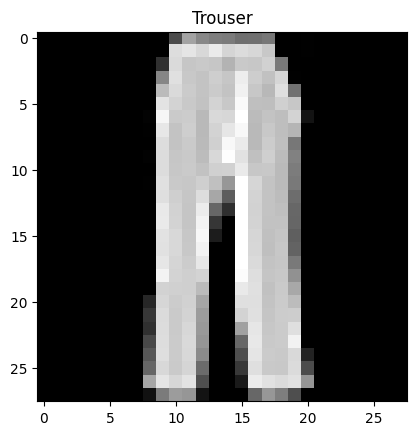

In [78]:
# Show a sample 
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_feature_batch), size = [1]).item()
img, label = train_feature_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_name[label])
plt.axis = False

## 4. Create our computer vision model

Let's just start with the previous model (baseline model) first or so can say we start from simplycity and add more when need


In [79]:
# create a flatten layer
flatten_model = nn.Flatten()

# get a simple sample 
x = train_feature_batch[0]

# Flatten the sample 
output = flatten_model(x)

# print out 
print(x.shape,output.shape)

torch.Size([1, 28, 28]) torch.Size([1, 784])


In [83]:
from torch import nn 
class FashionMNISTmodel(nn.Module):
	def __init__(self, input_shape:int, hidden_unit:int, output_shape:int):
		super().__init__()
		self.layers = nn.Sequential(
			nn.Flatten(),
			nn.Linear(in_features=input_shape,out_features=hidden_unit),
			nn.Linear(in_features=hidden_unit,out_features=output_shape)
		)

	def forward(self, input:torch.tensor):
		return self.layers(input)

In [87]:
torch.manual_seed(42)

INPUT_SHAPE = 28*28
HIDDEN_UNIT = 10
OUTPUT_SHAPE = len(class_name)

model = FashionMNISTmodel(
	input_shape = INPUT_SHAPE,
	hidden_unit = HIDDEN_UNIT,
	output_shape = OUTPUT_SHAPE
).to("cpu")

print(model.parameters())

<generator object Module.parameters at 0x00000180D43C91C0>


In [88]:
dummy_x = torch.rand([1,1,28,28])
model.evel()

model(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 4.1 Setup loss, optimizer and evaluation metrics

* Loss function - multi-class: `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent) 


In [100]:
from torchmetrics import Accuracy

# Accuracy calculate
accuracy_fn = Accuracy(task="multiclass", num_classes=10)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

### 4.2 Function to time our experiments

We need to track multiple criterias of the model
1. Model's performance (loss and accuracy values - like we used to do)
2. How fast it runs

In [91]:
from timeit import default_timer as timer
def print_train_time(start: float, 
					 end: float,
					 device: torch.device = None):
	
	run_time = end - start
	print(f"Train time on {device}: {run_time:.3f} seconds ")
	return run_time

In [92]:
start_time = timer()
end_time = timer()
print_train_time(start_time, end_time, None)

Train time on None: 0.000 seconds 


3.3300137147307396e-05

### 4.3 Creating a training loop and tracking a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate test loss *per batch*
4. Print out what's happening 
5. time it all

In [103]:
from tqdm.auto import tqdm

# set the seed - start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epoch
epochs = 3

# Create training and test loop 
for epoch in tqdm(range(epochs)):
	print(f"Epoch: {epoch}\n--------------")
	### training
	train_loss = 0
	# add a loop to loop through batches
	for batch, (X, y) in enumerate(train_dataloader):
		model.train()

		# forward the model
		y_pred = model(X)

		# calculate the loss
		loss = loss_fn(y_pred, y)
		train_loss += loss

		# zero gradient
		optimizer.zero_grad()

		# back propagation
		loss.backward()

		# optimzer
		optimizer.step()

		if batch % 400 == 0: 
			print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
	
	# Divide total train loss by length of train dastaloader
	train_loss /= len(train_dataloader)

	### Testing
	test_loss = 0
	for batch, (X, y) in enumerate(test_dataloader):
		model.eval()

		y_test = model(X)
		loss = loss_fn(y_test, y)

		test_loss += loss

		accuracy = accuracy_fn(y, y_test.argmax(dim=1))

	test_loss /= len(test_dataloader)
	train_loss /= len(train_dataloader)

	print(f"\nTrainLoss: {train_loss:.4f} | TestLoss: {test_loss:.4f} | TestAcc: {accuracy:.3f}")

train_time_end_on_cpu = timer()
total_train_time = print_train_time(train_time_start_on_cpu,
									train_time_end_on_cpu,
									device=str(next(model.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 33%|███▎      | 1/3 [00:06<00:12,  6.45s/it]


TrainLoss: 0.0003 | TestLoss: 0.6630 | TestAcc: 0.875
Epoch: 1
--------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 67%|██████▋   | 2/3 [00:12<00:06,  6.46s/it]


TrainLoss: 0.0003 | TestLoss: 0.6420 | TestAcc: 0.875
Epoch: 2
--------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 3/3 [00:19<00:00,  6.38s/it]


TrainLoss: 0.0003 | TestLoss: 0.6248 | TestAcc: 0.875
Train time on cpu: 19.154 seconds 


## 5. Make prediction and get Model results

In [111]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
			   data_loader: torch.utils. data.DataLoader,
			   loss_fn: torch.nn.Module,
			   accuracy_fn):
	loss, acc = 0, 0
	model.eval()
	with torch.inference_mode():
		for X, y in tqdm(data_loader):
			y_pred = model(X)

			loss += loss_fn(y_pred, y)
			acc += accuracy_fn(y, y_pred.argmax(dim=1))

		# Find the average loss/acc per batch
		loss /= len(data_loader)
		acc  /= len(data_loader)

	return {"model_name": model.__class__.__name__,
		 	"model_loss": loss.item(),
			"model_acc" : acc.numpy().item()}

model_results = eval_model(model, test_dataloader, loss_fn, accuracy_fn)
print(model_results)

100%|██████████| 313/313 [00:00<00:00, 409.15it/s]

{'model_name': 'FashionMNISTmodel', 'model_loss': 0.6248471736907959, 'model_acc': 0.7865415215492249}


## 6. Using GPU

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

### 6.1 Create a non-Linnear model 

In [116]:
class FashionMNISTmodelV1(nn.Module):
	def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
		super().__init__()
		self.layers = nn.Sequential(
			nn.Flatten(),
			nn.Linear(in_features = input_shape, out_features=hidden_units),
			nn.ReLU(),
			nn.Linear(in_features = hidden_units, out_features=output_shape),
			nn.ReLU(),
		)
	
	def forward(self, input: torch.Tensor):
		return self.layers(input)

In [118]:
torch.manual_seed(42)
model = FashionMNISTmodelV1(input_shape=28*28,
							hidden_units=10,
							output_shape=len(train_data.classes)).to(device)

print(model.state_dict())

OrderedDict([('layers.1.weight', tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
        [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
        [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
        ...,
        [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
        [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
        [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]],
       device='cuda:0')), ('layers.1.bias', tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
         0.0018,  0.0163], device='cuda:0')), ('layers.3.weight', tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
          0.2019,  0.2847],
        [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.3130, -0.0118,
          0.0932, -0.1864],
        [ 0.2488,  0.1500,  0.1907,  0.1457, -0.3050, -0.0580,  0.1643,  0.1565,
         -0.2877, -0.1792],
        [ 0.2305

### 6.1 Loss function and optimzier


In [ ]:
accuracy_fn = Accuracy(task="multiclass", num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.1)

### 6.2 Training/evaluating loop function 

This time we create a function for quick use since I have familiar with the torch work flow 

In [5]:
def train_step(model: torch.nn.Module,
			   data_loader: torch.utils.data.DataLoader,
			   loss_fn: torch.nn.Module,
			   optimizer: torch.optim.Optimizer,
			   accuracy_fn,
			   device: torch.device = device
			   ):
	
	train_loss, train_acc = 0, 0
	model.train()

	for X, y in data_loader:
		X, y = X.to(device), y.to(device)
		pred = model(X)

		loss = loss_fn(pred, y)
		acc = accuracy_fn(y, pred.argmax(dim=1))
		train_loss += loss
		train_acc += acc

		optimizer.zero_grad()

		loss.backward()

		optimizer.step()

	train_loss /= len(data_loader)
	train_acc /= len(data_loader)
	print(f"\nTrainLoss: {train_loss:.4f} | TrainAcc: {train_acc:.3f}")


In [6]:

def test_step(model: torch.nn.Module,
			   data_loader: torch.utils.data.DataLoader,
			   loss_fn: torch.nn.Module,
			   accuracy_fn,
			   device: torch.device = device
			   ):
	
	test_loss, test_acc = 0, 0

	model.eval()

	with torch.inference_mode():
		for X, y in data_loader:
			X, y = X.to(device), y.to(device)
			pred = model(X)

			loss = loss_fn(pred, y)
			acc = accuracy_fn(y, pred.argmax(dim=1))
			test_loss += loss
			test_acc += acc

		test_loss /= len(data_loader)
		test_acc /= len(data_loader)
		print(f"\nTestLoss: {test_loss:.4f} | TestAcc: {test_acc:.3f}")